# Lorenz 96 Gym Wrapper and RL Starter

The full L96 system is described by these equations:
$$
\frac{dX_k}{dt} = -X_{k-1}(X_{k-2}-X_{k+1})-X_k+F-hc\bar{Y}_k
$$
$$
\frac{dY_k}{dt} = c [ -b Y_{k-1}(Y_{k-2}-Y_{k+1})-Y_k + \frac{h}{J}X_k ]
$$
with parameters $\theta = \{F, h, c, b\}$ which are set to $\{10, 1, 10, 10\}$.

The parameterization problem is to replace the last term in the X equation $-hc\bar{Y}_k := B_k$ with an approximation $P(X_k) \approx B_k$.

We will look at the weather prediction problem, where the goal is to minimize the error between the parameterized L96 system and the actual system after some lead time.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Create a reference dataset with the L96 class

For convenient experimentation, I wrote a L96 class, which we will use now to create a reference dataset.

In [3]:
from L96 import L96TwoLevel

In [4]:
# Load spun-up initial conditions
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')

In [5]:
l96_ref = L96TwoLevel(X_init=initX, Y_init=initY, noYhist=True)

In [6]:
# Time is in model time units
l96_ref.iterate(10)

In [8]:
# Get the history
# h = l96_ref.history

<xarray.Dataset>
Dimensions:  (time: 101, x: 36, y: 360)
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 9.5 9.6 9.7 9.8 9.9 10.0
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
Data variables:
    X        (time, x) float64 7.222 2.999 1.425 3.226 ... -1.605 3.599 5.081
    B        (time, x) float64 -3.124 -1.743 -0.7543 ... 0.4533 -1.158 -2.23
    Y_mean   (time, x) float64 0.3124 0.1743 0.07543 ... -0.0446 0.1172 0.2215
    Y2_mean  (time, x) float64 0.19 0.05604 0.006333 ... 0.01672 0.0443 0.1178

In [11]:
# Or we can just download a larger dataset
!wget -O data/L96TwoLevel_ref.nc https://ndownloader.figshare.com/files/16946225

--2019-08-07 18:54:39--  https://ndownloader.figshare.com/files/16946225
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.249.74.7, 52.208.107.190, 108.128.157.174, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.249.74.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/16946225/L96TwoLevel_ref.nc [following]
--2019-08-07 18:54:39--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/16946225/L96TwoLevel_ref.nc
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.96.210
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.96.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232012790 (221M) [application/x-netcdf]
Saving to: ‘data/L96TwoLevel_ref.nc’

data/L96TwoLevel_re 100%[===================>] 221.26M  28.8MB/s    in 8.6s    

2019-08-07 18:54:48 (25.7 MB/s) - ‘data/L96TwoLevel_ref.

In [12]:
h = xr.open_dataset('./data/L96TwoLevel_ref.nc'); h

<xarray.Dataset>
Dimensions:  (time: 200001, x: 36, y: 360)
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 ... 2e+04 2e+04 2e+04 2e+04
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
Data variables:
    X        (time, x) float64 ...
    B        (time, x) float64 ...
    Y_mean   (time, x) float64 ...
    Y2_mean  (time, x) float64 ...

## Train a simple parameterization using the real data

The simplest parameterization one can fit is a linear regression.

In [13]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)

In [19]:
from sklearn.linear_model import LinearRegression

In [21]:
lr = LinearRegression()
lr.fit(features[:, None], targets[:, None])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
true_slope, true_intercept = lr.coef_[0, 0], lr.intercept_[0]; true_slope, true_intercept

(-0.30716963810423836, -0.2111813639516099)

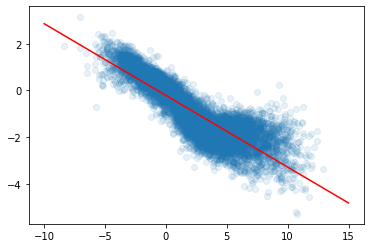

In [29]:
plt.scatter(features[::1000], targets[::1000], alpha=0.1)
x = np.linspace(-10, 15, 10)
plt.plot(x, true_slope * x + true_intercept, c='r')

## Make a forecast with the parameterization

This way we can get a good estimate of how good the best linear regression parameterization can be.

Note that we are also using a coarser time step for the parameterized model. 0.01 instead of 0.001 for the true two-level model.

In [215]:
lr.predict(l96_ref.X[:, None])[:, 0]

array([-0.33539272, -0.45591308, -2.26806857, -0.17372733, -1.46536677,
       -4.00259883, -1.0781449 , -0.17576106, -1.40676528, -1.88951731,
       -0.1951514 ,  0.43905387, -0.82077864, -2.95578707, -3.02355522,
       -0.95054093,  0.50880406, -0.62572524, -1.85939702, -1.50437246,
       -0.83049549,  0.27903417, -0.74813751, -0.58279   , -1.7372581 ,
       -3.08782031, -0.97264205, -0.08850853,  0.07338688,  0.66391416,
       -1.41612909, -3.23813259, -1.0005602 ,  0.28177427, -1.3167808 ,
       -1.77180554])

In [216]:
class LRParameterization():
    """Simple class that returns the linear regression prediction."""
    def __init__(self, lr):
        self.lr = lr
    def __call__(self, x):
        return lr.predict(x[:, None])[:, 0]

In [217]:
l96_lr = L96TwoLevel(X_init=initX, parameterization=LRParameterization(lr), dt=0.01)

In [218]:
l96_lr.iterate(15)

In [219]:
h_lr = l96_lr.history

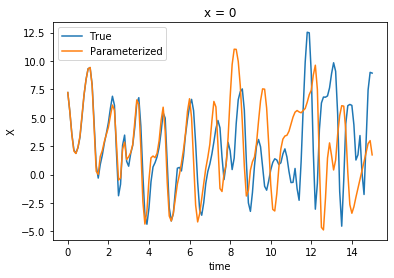

In [220]:
# Plot the evolution of one variable
h.X.sel(time=slice(0, 15), x=0).plot(label='True')
h_lr.X.sel(time=slice(0, 15), x=0).plot(label='Parameterized')
plt.legend()

### Get mean MSE over many forecasts.

In [245]:
# This takes a few minutes for 50 iterations
mses = []
persistence_mses = []
for t in tqdm(np.random.choice(h.time.isel(time=slice(0, -int(15/0.1))), 50)):
    X = h.X.sel(time=t)
    true = h.X.sel(time=slice(t, t+15))
    l = L96TwoLevel(X_init=X.values, parameterization=LRParameterization(lr), noprog=True, dt=0.01)
    l.iterate(15)
    true['time'] = l.history.time
    mses.append(((l.history.X - true)**2).mean('x'))
    persistence_mses.append(((X - true)**2).mean('x'))

In [246]:
mse = xr.concat(mses, 'sample')
persistence_mse = xr.concat(persistence_mses, 'sample')

In [247]:
climatology = h.X.mean('time')
clim_mse = ((h.X - climatology)**2).mean(('x', 'time'))

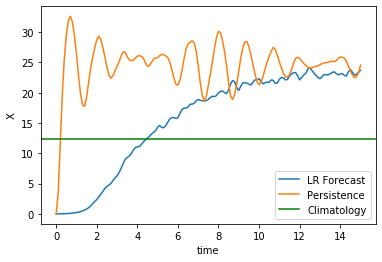

In [248]:
mse.mean('sample').plot(label='LR Forecast'); 
persistence_mse.mean('sample').plot(label='Persistence') 
plt.axhline(clim_mse, c='g', label='Climatology')
plt.legend()

In [249]:
# This is the average MSE, i.e. the best a linear regression can do
mse.mean('sample').sel(time=1).values, mse.std('sample').sel(time=1).values

(array(0.22540668), array(0.16823196))

So without any in-depth analysis it seems like the plausible forecast horizon is at around 4 time units. For this task here, we can choose a lead time of 1-2 time units.

## Set up L96 Gym environment

The first think we need to do is to add a method to out L96 class that allows us to compute B separately and feed it to the time stepper of the L96 class.

In [126]:
from L96 import *
import gym

In [127]:
class L96TwoLevelRL(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def step_with_B(self, B):
        k1_X = self._rhs_X_dt(self.X, B=B)
        k2_X = self._rhs_X_dt(self.X + k1_X / 2, B=B)
        k3_X = self._rhs_X_dt(self.X + k2_X / 2, B=B)
        k4_X = self._rhs_X_dt(self.X + k3_X, B=B)

        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)
#         self.X += B * self.dt

        self.step_count += 1
        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)
            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())

In [142]:
class L96Gym(gym.Env):
    def __init__(self, history, lead_time=1., dt=0.01, action_bounds=(-20,20)):
        """Lorenz 96 gym environment.
        
        Every reset a new random state from the history file is chosen for initial 
        conditions. The reward is zero for all steps until the lead time is reached.
        Then the firal reward is the negative MSE to the "true" model.
        
        Both state and action of size K(=36 by default) x 1. The trailing dimension 
        is for convenience, since many ML frameworks require a sample dimension.
        
        Args:
          history: reference forecast history from which to draw initial conditions 
                   and the "true" forecast
          lead_time: forecast lead time in L96 model time units
          dt: Time step of parameterized model
          action_bounds: clip predicted actions at these bounds
        """
        self.history, self.lead_time, self.dt = history, lead_time, dt
        self.nsteps = self.lead_time // self.dt
        self.step_count = 0
        
        self.action_space = gym.spaces.Box(
            low=np.array([action_bounds[0]]), 
            high=np.array([action_bounds[1]])
        )
        self.observation_space = gym.spaces.Box(-np.array([np.inf]), np.array([np.inf]))
    
    def reset(self):
        self.init_time = np.random.choice(h.time[:-int(self.lead_time/0.1)])
        self.X_init = h.X.sel(time=self.init_time, method='nearest').values
        self.fc_target = h.X.sel(time=self.init_time+self.lead_time, method='nearest').values
        
        self.l96 = L96TwoLevelRL(noYhist=True, X_init=self.X_init, dt=self.dt, save_dt=self.dt)
        state = self.l96.X.copy()
        self.step_count = 0
        return state[:, None]
    
    def step(self, action):
        self.l96.step_with_B(action.squeeze())
        state = self.l96.X.copy()
        self.step_count += 1
        if self.step_count >= self.nsteps:
            done = True
            reward = -((state - self.fc_target)**2).mean()
        else:
            done = False
            reward = 0
        return state[:, None], reward, done, None

### Test out the environment

Just a sanity check...

In [241]:
env = L96Gym(history=h, lead_time=1, dt=0.01)
state = env.reset()
state.shape

(36, 1)

In [242]:
lr.predict(state).shape

(36, 1)

In [243]:
# Let's see how our linear regression trained on the perfect data performs
rewards = []
for i in tqdm(range(50)):
    done = False
    while not done:
        action = lr.predict(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
    state = env.reset()
    rewards.append(reward)

In [244]:
np.mean(rewards), np.std(rewards)

(-0.279866234953732, 0.3102847261822599)

I am slightly confused that the mean reward is always a little greater that the mean MSE we computed above for the LR regression. It is within the standard deviation for sure, but still... 

In [239]:
state = env.reset()
l96_lr = L96TwoLevel(X_init=state.squeeze(), parameterization=LRParameterization(lr), noprog=True,
                     dt=0.01)
l96_lr.iterate(1)
done = False
while not done:
    action = lr.predict(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state

6.37670072978682

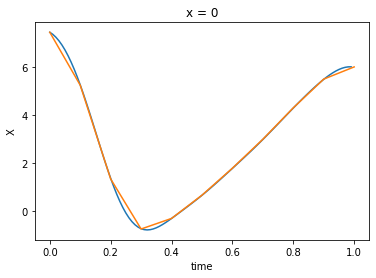

In [240]:
env.l96.history.X.isel(x=0).plot()
l96_lr.history.X.isel(x=0).plot()
env.fc_target[0]

But from the test above it seems that we are doing exactly the same. Let's just assume there are no bugs...

## Implement DDPG

I modified this implementation from https://github.com/higgsfield/RL-Adventure-2/blob/master/5.ddpg.ipynb

In [270]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import deque
import random
from IPython.display import clear_output

In [262]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda

False

### Replay Buffer

We have to slightly change the replay buffer. We take actions separately for every point in space with shared parameters, other than in regular RL problems, where only one action is taken every time step

In [256]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        if state.ndim == 1:
            self.buffer.append([state, action, reward, next_state, done])
        else:
            for i in range(len(state)):
                self.buffer.append([
                    state[i], action[i], reward, next_state[i], done])
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

### DDPG Update

In [258]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

### Value and Policy networks

In [259]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class PolicyNetworkLinear(nn.Module):
    def __init__(self, num_inputs, num_actions, init_w=3e-3):
        super(PolicyNetworkLinear, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, num_actions, bias=True)
        self.linear1.weight.data.uniform_(-init_w, init_w)
        self.linear1.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        return self.linear1(state)
    
    def get_action(self, state):
        state = np.atleast_2d(state)
        state  = torch.FloatTensor(state).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy().squeeze() 

### Setup

In [275]:
# Plotting function to track progress
def plot(episode, rewards, weights, biases):
    clear_output(True)
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].set_title('frame %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    axs[0].plot(rewards)
    axs[1].plot(weights)
    axs[1].plot(biases)
    axs[1].axhline(true_slope, c='blue', alpha=0.5, label='slope')
    axs[1].axhline(true_intercept, c='orange', alpha=0.5, label='bias')
    axs[1].legend()
    axs[2].scatter(features[::1000], targets[::1000], s=5, alpha=0.2)
    a = np.linspace(-10,15)
    b = policy_net.get_action(a[:, None])
    axs[2].plot(a, b, c='orange')
    plt.show()

In [276]:
env = L96Gym(history=h, lead_time=1)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetworkLinear(state_dim, action_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetworkLinear(state_dim, action_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [277]:
max_frames  = 100_000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128
weights = []
biases = []

### Run

In [ ]:
episode = 0
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        # I implement exploration noise like this
        # action = action * noise_slope + noise_bias
        noise_slope = np.random.normal(1, 0.1)
        noise_bias = np.random.normal(0, 0.1)
        action = action * noise_slope + noise_bias
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action[:, None], reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards, weights, biases)
        
        if done:
            weights.append(policy_net.linear1.weight.cpu().detach().numpy()[0].copy())
            biases.append(policy_net.linear1.bias.cpu().detach().numpy()[0].copy())
            episode += 1
            break
    
    rewards.append(episode_reward)

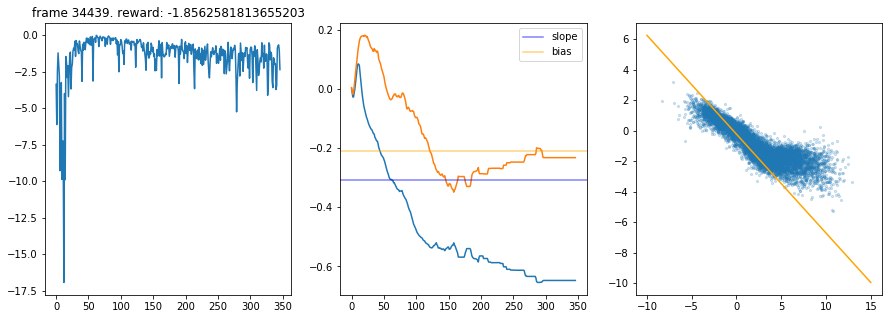

In [279]:
plot(frame_idx, rewards, weights, biases)

So I would say it kind of works, as in it doesn't do anything completely crazy, but it doesn't seem to be able to find the right solution or lower the reward. Also, it often seems to get stuck with a certain set of parameters.

Here are some things that I know I didn't check:

- Should the exploration noise decrease with time? Is the way I implemented exploration noise correct? It currently is random for every time step. Should there be any memory?
- I never played with any of the hyper-parameters of the DDPG algorithm: buffer size, learning rates, batch_size, soft_tau
- Value net: this is still a regular neural network, even though the policy net is just a linear regression. Should they match in complexity? Could the "getting stuck" have to do with the value nets gradients vanishing?

## Now check whether this also works for a neural network

Note that I did not pretrain the neural network. To simulate a "wrong" pretraining, one option is to run a second two-level reference simulation with different parameters for F, b, c, h and use this data to fit a network.

In [283]:
class PolicyNetworkNN(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetworkNN, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    def get_action(self, state):
        state = np.atleast_2d(state)
        state  = torch.FloatTensor(state).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy().squeeze()

### Setup

In [292]:
# Plotting function to track progress
def plot(episode, rewards, weights, biases):
    clear_output(True)
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].set_title('frame %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    axs[0].plot(rewards)
    axs[1].scatter(features[::1000], targets[::1000], s=5, alpha=0.2)
    a = np.linspace(-10,15)
    b = policy_net.get_action(a[:, None])
    axs[1].plot(a, b, c='orange')
    plt.show()

In [299]:
env = L96Gym(history=h, lead_time=1)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetworkNN(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetworkNN(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [300]:
max_frames  = 100_000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128
weights = []
biases = []

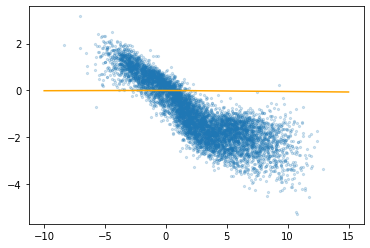

In [301]:
# This is our starting point
a = np.linspace(-10,15)
b = policy_net.get_action(a[:, None])
plt.plot(a, b, c='orange')
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.2);

### Run

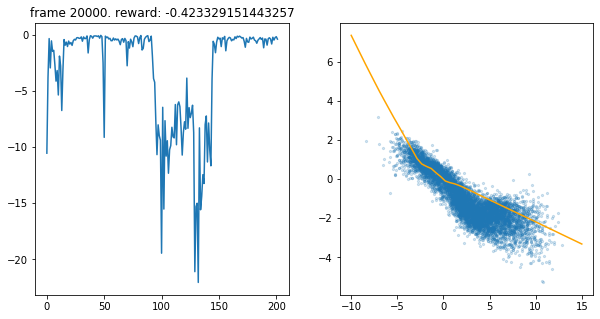

In [ ]:
episode = 0
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        # I implement exploration noise like this
        # action = action * noise_slope + noise_bias
        noise_slope = np.random.normal(1, 0.1)
        noise_bias = np.random.normal(0, 0.1)
        action = action * noise_slope + noise_bias
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action[:, None], reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards, weights, biases)
        
        if done:
            episode += 1
            break
    
    rewards.append(episode_reward)

Again, the algorithm seems to find a good solution pretty quickly but then doesn't seem to be able to converge. Rather it suddenly breaks down. Is the learning rate too big? Would a method like PPO (which, from what I understand, limits the size of the update) be more appropriate?

My currently problem is that there are so many algorithms and so many knobs to tune, and I have zero experience. Help! ;)